## Time series forecasting

* This seminar contains materials about time series forecasting.
* We use data on passenger traffic for Finnish airports.
* You can load the air traffic data in Europe from
http://ec.europa.eu/eurostat/web/transport/data/database

Outline:
1. Working with timeseries data in pandas
2. Modification of time series for better modeling
3. Simple time series analytics
4. Construction of ARIMA model
5. Generation of additional features
6. Construction of linear model with additional features

During preparation of the seminars the following materials were used:
* An example of time series forecasting with Python https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
* Lection by E.Ryabenko on Time series forecasting (in Russian) https://youtu.be/u433nrxdf5k

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline

In [2]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
rcParams['font.size'] = 20

In [3]:
from sklearn.metrics import mean_squared_error, r2_score

# Load the data and look through it

In [4]:
data = pd.read_csv('data/finland_air.csv')

In [5]:
print(data.head())
print('\n Data Types:')
print(data.dtypes)
print(data.columns)

      TIME  PASSENGERS
0  2001M01    439753.0
1  2001M02    409945.0
2  2001M03    489109.0
3  2001M04    517510.0
4  2001M05    536096.0

 Data Types:
TIME           object
PASSENGERS    float64
dtype: object
Index(['TIME', 'PASSENGERS'], dtype='object')


In [6]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%YM%m')
data = pd.read_csv('data/finland_air.csv', parse_dates=['TIME'], 
                   date_parser=dateparse)

In [7]:
print(data.head())
print(data.dtypes)

        TIME  PASSENGERS
0 2001-01-01    439753.0
1 2001-02-01    409945.0
2 2001-03-01    489109.0
3 2001-04-01    517510.0
4 2001-05-01    536096.0
TIME          datetime64[ns]
PASSENGERS           float64
dtype: object


In [8]:
data.set_index('TIME', inplace=True)

In [9]:
data.head()

,PASSENGERS
TIME,
2001-01-01,439753.0
2001-02-01,409945.0
2001-03-01,489109.0
2001-04-01,517510.0
2001-05-01,536096.0


## Work with dates in pandas 

In [10]:
print(datetime.now().time())

date_object = datetime.strptime('May 12 2016  2:25AM', '%b %d %Y %I:%M%p')
print(date_object)

10:35:40.192949
2016-05-12 02:25:00


In [11]:
# In pandas to work with dates we use functions close to datetime library functions
print(datetime(2001, 1, 1))
print(data.loc[datetime(2001, 1, 1, 0)])

2001-01-01 00:00:00
PASSENGERS    439753.0
Name: 2001-01-01 00:00:00, dtype: float64


In [12]:
#1. let us get range of values
print(data['2001-01-01':'2001-05-01'])

#2. We can specify only one end of the interval using ':'
print(data[:'2001-01-01'])

            PASSENGERS
TIME                  
2001-01-01    439753.0
2001-02-01    409945.0
2001-03-01    489109.0
2001-04-01    517510.0
2001-05-01    536096.0
            PASSENGERS
TIME                  
2001-01-01    439753.0


In [13]:
print(data['2002'])

            PASSENGERS
TIME                  
2002-01-01    421936.0
2002-02-01    430392.0
2002-03-01    514893.0
2002-04-01    515863.0
2002-05-01    544529.0
2002-06-01    592374.0
2002-07-01    538596.0
2002-08-01    552192.0
2002-09-01    548472.0
2002-10-01    546930.0
2002-11-01    456303.0
2002-12-01    546519.0


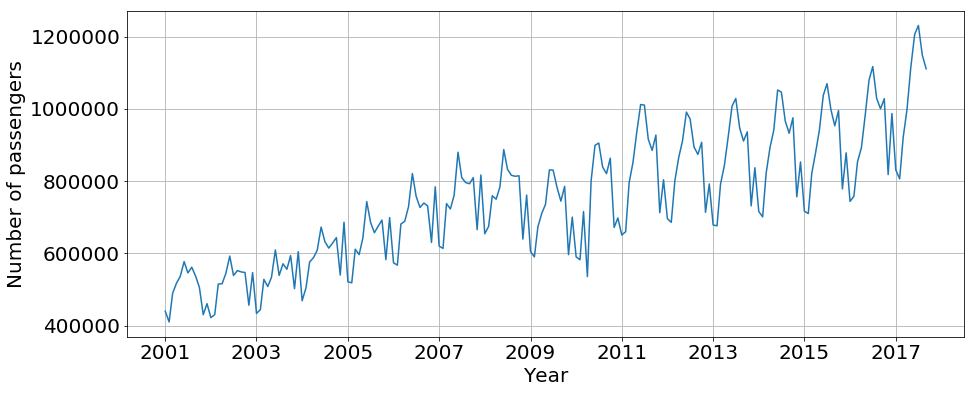

In [14]:
plt.plot(data['PASSENGERS'])
plt.grid()
plt.xlabel('Year')
plt.ylabel('Number of passengers');

## Test time series for stationarity

In [15]:
# To work with timeseries data we use python statmodels library that contains also a lot of statistical tests
from statsmodels import tsa
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [16]:
def test_stationarity(timeseries, window=12):
  r""" Test if provided time series is stationary using visualization and Dickey-Fuller test

  Parameters
  ----------
  timeseries : list
    uniform in time timeseries
  window : int
    size of rolling window
  """ 
  
  # Statistics for rolling mean:
  rolling_mean_series = pd.DataFrame.rolling(timeseries, window=window).mean()
  rolling_std_series = pd.DataFrame.rolling(timeseries, window=window).std()

  # Plot values of statistics:
  plt.plot(timeseries, label='Initial time series')
  plt.plot(rolling_mean_series, label='Rolling mean')
  plt.plot(rolling_std_series, label = 'Rolling standard deviation')
  plt.legend(loc='best')
  
  # Run Dickey-Fuller test for stationarity
  print('Results of Dickey-Fuller test:')
  df_test_values = adfuller(timeseries, autolag='AIC')
  df_test_results = pd.Series(df_test_values[0:4], index=['Statistics', 'p-value', 
                                                          'Length of history', 'Number of observations'])
  for key, value in df_test_values[4].items():
      df_test_results['Critical value (%s)'%key] = value
  print(df_test_results)

In [17]:
 tsa.stattools.adfuller?

Results of Dickey-Fuller test:
Statistics                 -0.143264
p-value                     0.944955
Length of history          14.000000
Number of observations    186.000000
Critical value (1%)        -3.466005
Critical value (5%)        -2.877208
Critical value (10%)       -2.575122
dtype: float64


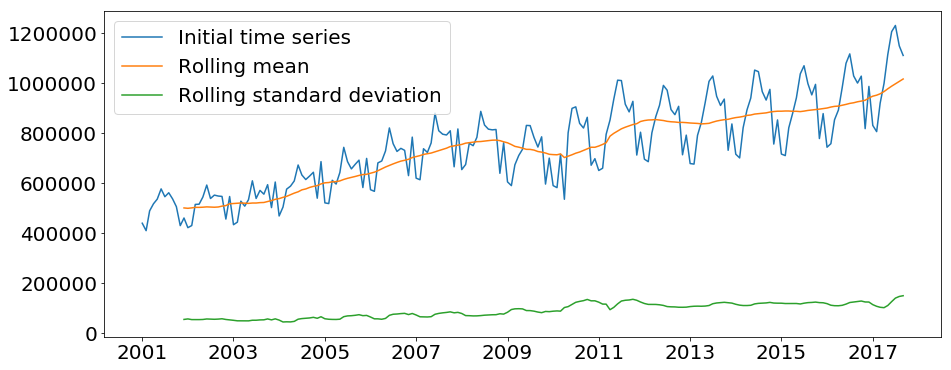

In [18]:
test_stationarity(data['PASSENGERS'])

# How to make time series stationarity?

* logarithm it
* compute rolling mean 
* substract exponential rolling mean 
* examine changes in time series

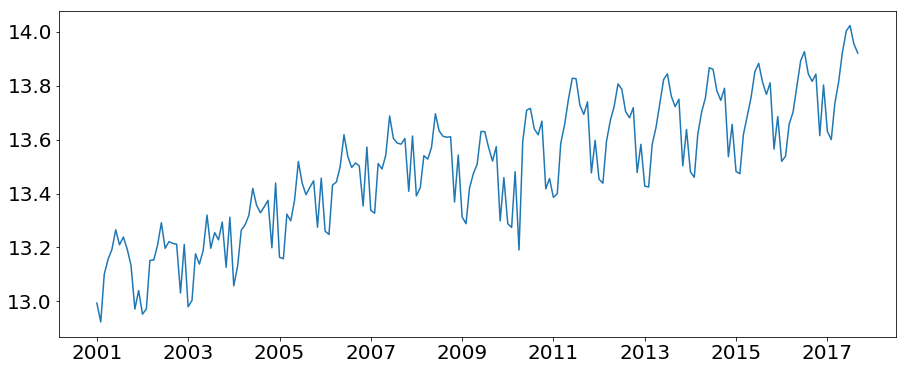

In [19]:
log_data = np.log(data)
plt.plot(log_data);

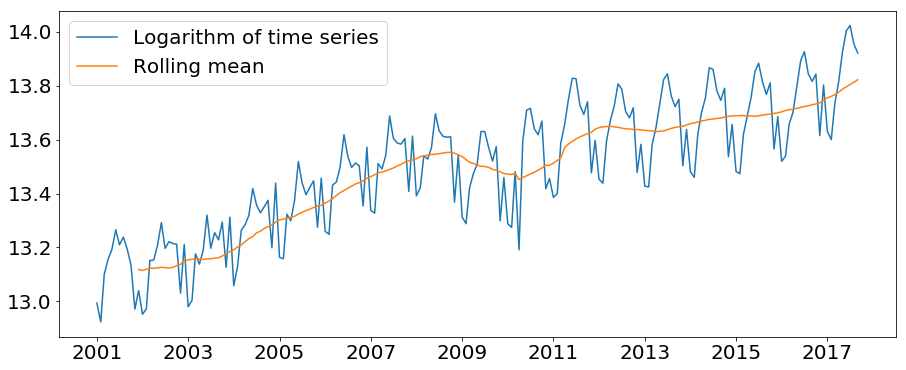

In [20]:
window_size = 12
moving_average = pd.DataFrame.rolling(log_data, window_size).mean()
plt.plot(log_data, label='Logarithm of time series')
plt.plot(moving_average, label='Rolling mean')
plt.legend();

In [21]:
log_data_residuals = log_data - moving_average
log_data_residuals.head(12)

,PASSENGERS
TIME,
2001-01-01,NaN
2001-02-01,NaN
2001-03-01,NaN
2001-04-01,NaN
2001-05-01,NaN
2001-06-01,NaN
2001-07-01,NaN
2001-08-01,NaN
2001-09-01,NaN


Results of Dickey-Fuller test:
Statistics                 -3.274267
p-value                     0.016069
Length of history          15.000000
Number of observations    174.000000
Critical value (1%)        -3.468502
Critical value (5%)        -2.878298
Critical value (10%)       -2.575704
dtype: float64


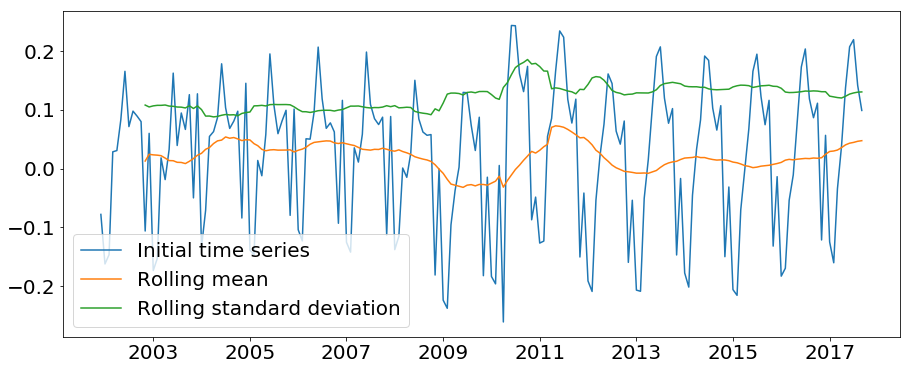

In [22]:
log_data_residuals.dropna(inplace=True)
test_stationarity(log_data_residuals['PASSENGERS'])

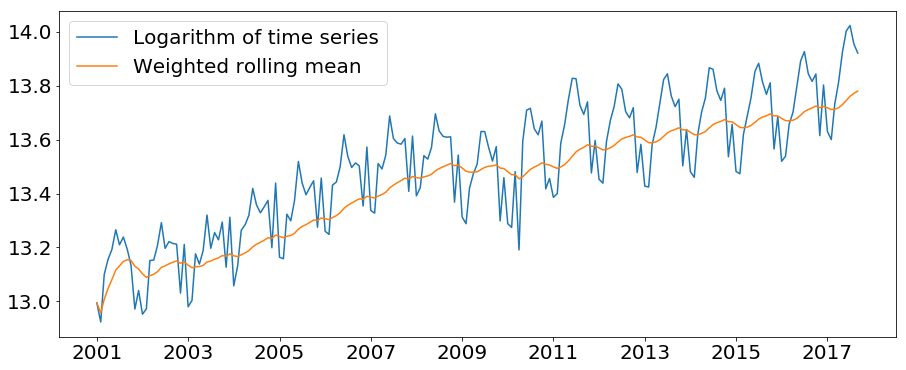

In [23]:
exp_weighted_average = pd.DataFrame.ewm(log_data, halflife=window_size).mean()
plt.plot(log_data, label='Logarithm of time series')
plt.plot(exp_weighted_average, label='Weighted rolling mean')
plt.legend();

Results of Dickey-Fuller test:
Statistics                 -3.109352
p-value                     0.025869
Length of history          15.000000
Number of observations    185.000000
Critical value (1%)        -3.466201
Critical value (5%)        -2.877293
Critical value (10%)       -2.575168
dtype: float64


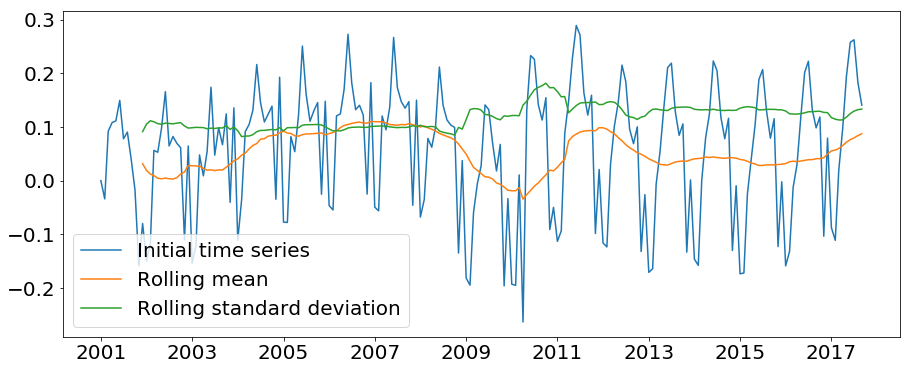

In [24]:
log_data_exp_residuals = log_data - exp_weighted_average
test_stationarity(log_data_exp_residuals['PASSENGERS'])

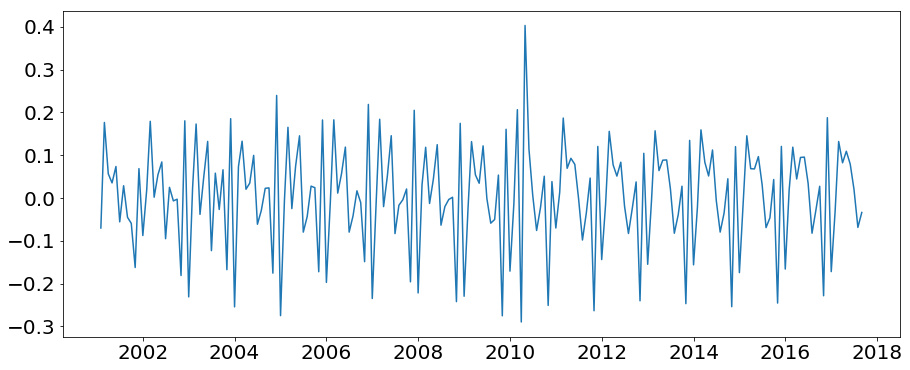

In [25]:
log_data_difference = log_data - log_data.shift()
plt.plot(log_data_difference);

Results of Dickey-Fuller test:
Statistics                 -3.425459
p-value                     0.010121
Length of history          13.000000
Number of observations    186.000000
Critical value (1%)        -3.466005
Critical value (5%)        -2.877208
Critical value (10%)       -2.575122
dtype: float64


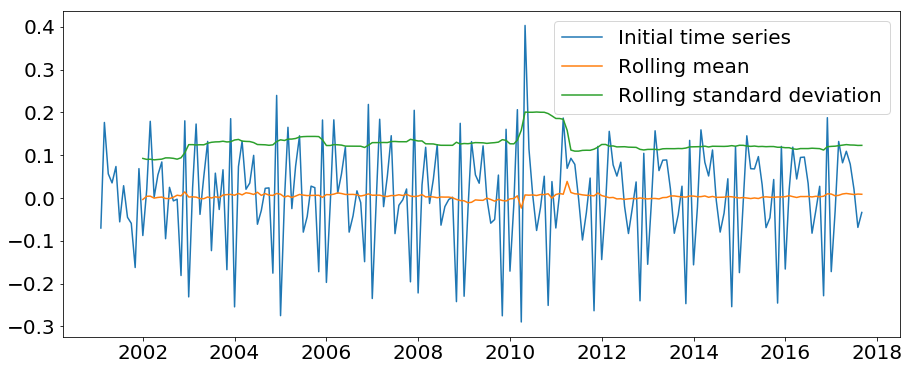

In [26]:
log_data_difference.dropna(inplace=True)
test_stationarity(log_data_difference['PASSENGERS'])

# Split time series to components

We consider three main components iin time series:
* Trend
* Seasonality
* Residuals

In [27]:
from statsmodels.tsa import seasonal

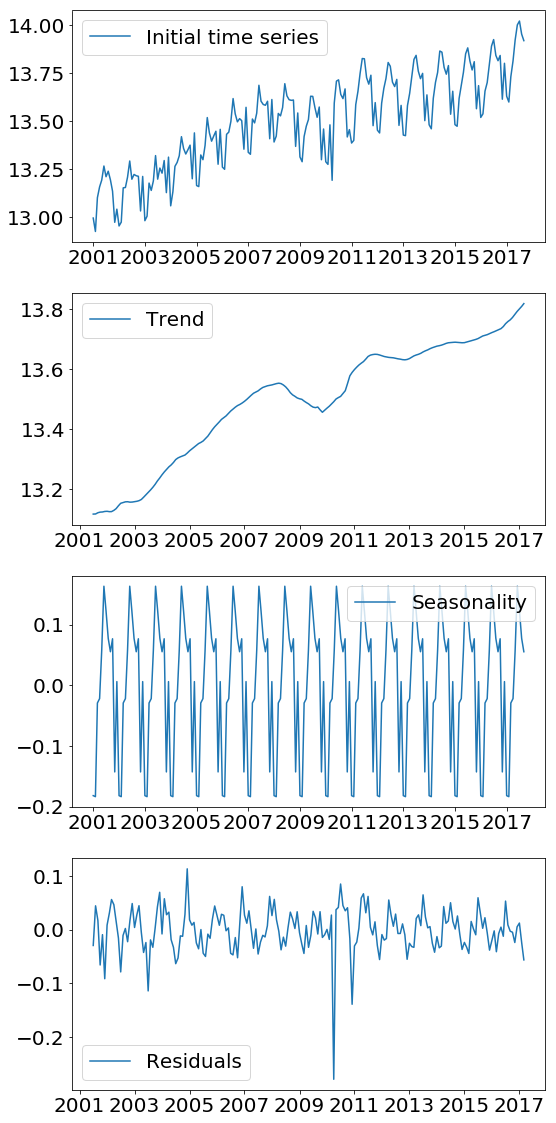

In [28]:
decomposition = seasonal.seasonal_decompose(log_data)

trend_part = decomposition.trend
seasonal_part = decomposition.seasonal
residual_part = decomposition.resid

plt.figure(figsize=(8, 16))
plt.subplot(411)
plt.plot(log_data, label='Initial time series')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_part, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_part, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_part, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

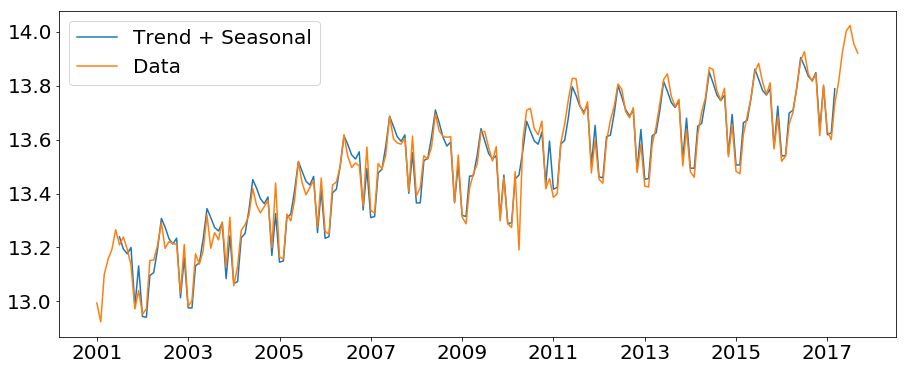

In [29]:
plt.plot(trend_part + seasonal_part, label='Trend + Seasonal')
plt.plot(log_data, label='Data')
plt.legend(loc='upper left')

Results of Dickey-Fuller test:
Statistics               -5.737060e+00
p-value                   6.402053e-07
Length of history         1.100000e+01
Number of observations    1.770000e+02
Critical value (1%)      -3.467845e+00
Critical value (5%)      -2.878012e+00
Critical value (10%)     -2.575551e+00
dtype: float64


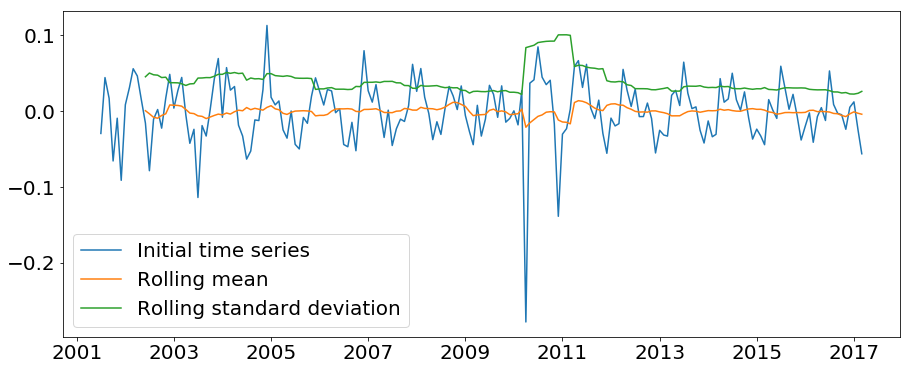

In [30]:
log_data_decomposition = residual_part
log_data_decomposition.dropna(inplace=True)
test_stationarity(log_data_decomposition['PASSENGERS'])

# Discovering autocorrelations

We use two functions: 
* autocorrelation function: correlation with a present value and a past value
* partial autocorrelation function: correlation with a present value and a past value taking into account previous correlations

In [31]:
from statsmodels.tsa.stattools import acf, pacf

In [32]:
lag_autocorrelation_function = tsa.stattools.acf(log_data_difference, nlags=20)
lag_partial_auto_correlation_function = tsa.stattools.pacf(log_data_difference, nlags=20, method='ols')

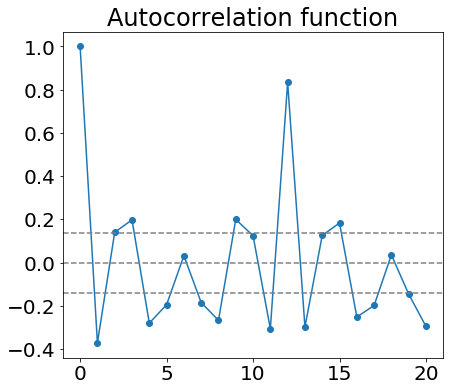

In [33]:
# Autocorrelation function: 
plt.subplot(121) 
plt.plot(lag_autocorrelation_function, '-o')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96 / np.sqrt(len(log_data_difference)), linestyle='--', color='gray')
plt.axhline(y=1.96 / np.sqrt(len(log_data_difference)), linestyle='--', color='gray')
plt.title('Autocorrelation function');

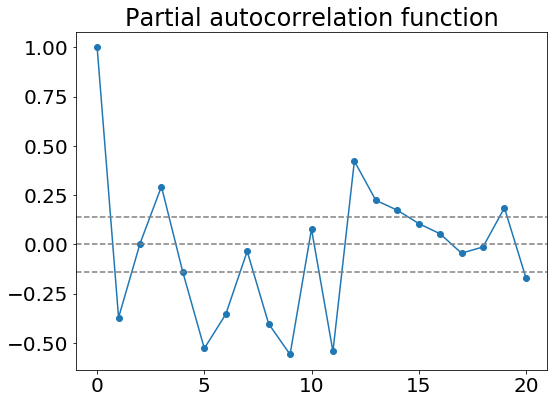

In [34]:
# Partial autocorrelation function:
plt.subplot(122)
plt.plot(lag_partial_auto_correlation_function, '-o')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96 / np.sqrt(len(log_data_difference)), linestyle='--', color='gray')
plt.axhline(y=1.96 / np.sqrt(len(log_data_difference)), linestyle='--', color='gray')
plt.title('Partial autocorrelation function')
plt.tight_layout()

## ARIMA models

There are two types of terms in ARIMA models:
* AR(IMA) - autoregression
* (ARI)MA - moving average

In [35]:
from statsmodels.tsa.arima_model import ARIMA

### Autoregression AR model

AR(1) process
\begin{equation}
  y_t = \varphi y_{t-1} + \varepsilon_{t} ,\,\,\,\{\varepsilon_{t}\}_{t\geq1} \sim WN(0, \sigma^2).
\end{equation}

AR(k) process
\begin{equation}
  y_t = \sum_{i = 1}^k \varphi_i y_{t-i} + \varepsilon_{t} ,\,\,\,\{\varepsilon_{t}\}_{t\geq1} \sim WN(0, \sigma^2).
\end{equation}

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  

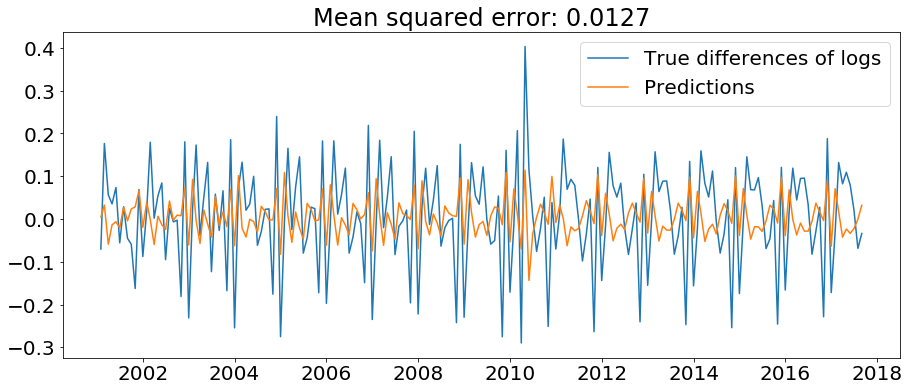

In [36]:
model = ARIMA(log_data, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  

plt.plot(log_data_difference, label='True differences of logs')
plt.plot(results_AR.fittedvalues, label='Predictions')
plt.title('Mean squared error: %.4f' % mean_squared_error(results_AR.fittedvalues, log_data_difference['PASSENGERS']));
plt.legend();

### Moving average model MA

MA(1) model:
\begin{equation}
  y_t = \varepsilon_t + \theta \varepsilon_{t - 1},\,\,\,\{\varepsilon_t\}_{t\geq1} \sim WN(0,\sigma^2).
\end{equation}

MA(k) model:
\begin{equation}
  y_t = \varepsilon_t + \sum_{i = 1}^k \theta_i \varepsilon_{t - i},\,\,\,\{\varepsilon_t\}_{t\geq1} \sim WN(0,\sigma^2).
\end{equation}

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  

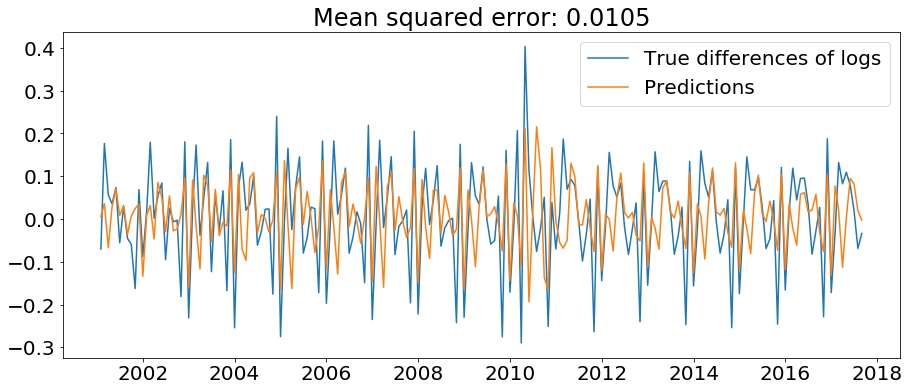

In [37]:
model = ARIMA(log_data, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  

plt.plot(log_data_difference, label='True differences of logs')
plt.plot(results_MA.fittedvalues, label='Predictions')
plt.title('Mean squared error: %.4f' % mean_squared_error(results_MA.fittedvalues, log_data_difference['PASSENGERS']));
plt.legend();

### Combined ARIMA model

Both AR and MA terms

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  

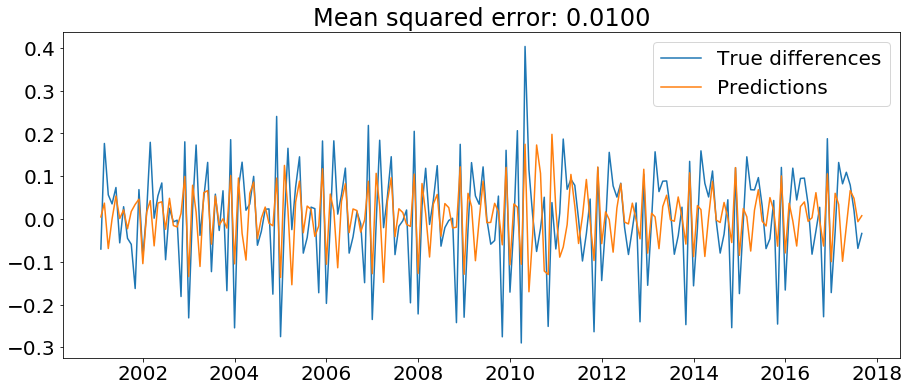

In [38]:
model = ARIMA(log_data, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(log_data_difference, label='True differences')
plt.plot(results_ARIMA.fittedvalues, label='Predictions')
plt.title('Mean squared error: %.4f' % mean_squared_error(results_ARIMA.fittedvalues, 
                                                          log_data_difference['PASSENGERS']));
plt.legend();

In [39]:
results_ARIMA.summary(0)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.PASSENGERS   No. Observations:                  200
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 176.385
Method:                       css-mle   S.D. of innovations              0.100
Date:                Wed, 20 Jun 2018   AIC                           -340.771
Time:                        10:35:47   BIC                           -320.981
Sample:                    02-01-2001   HQIC                          -332.762
                         - 09-01-2017                                         
======================================================================================
                         coef    std err          z      P>|z|        [0.0        1.0]
--------------------------------------------------------------------------------------
const                  0.0049      0.007      0.687      0.493        -inf         inf
ar.L1.D.PASSENGERS    -0.2051      0.225     -0.912      0.363        -inf         inf
ar.L2.D.PASSENGERS    -0.3182      0.133     -2.398      0.017        -inf         inf
ma.L1.D.PASSENGERS    -0.2176      0.195     -1.115      0.266        -inf         inf
ma.L2.D.PASSENGERS     0.7467      0.056     13.365      0.000        -inf         inf
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.3222           -1.7431j            1.7726           -0.2791
AR.2           -0.3222           +1.7431j            1.7726            0.2791
MA.1            0.1457           -1.1480j            1.1572           -0.2299
MA.2            0.1457           +1.1480j            1.1572            0.2299
-----------------------------------------------------------------------------
"""

## Go back to initial scale

In [40]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

TIME
2001-02-01    0.004864
2001-03-01    0.037090
2001-04-01   -0.069006
2001-05-01   -0.000105
2001-06-01    0.053651
dtype: float64


In [41]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

TIME
2001-02-01    0.004864
2001-03-01    0.041954
2001-04-01   -0.027052
2001-05-01   -0.027157
2001-06-01    0.026494
dtype: float64


In [42]:
predictions_ARIMA_log = pd.Series(log_data['PASSENGERS'].iloc[0], index=log_data.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

TIME
2001-01-01    12.993968
2001-02-01    12.998832
2001-03-01    13.035922
2001-04-01    12.966916
2001-05-01    12.966811
dtype: float64

## Time series prediction using given model

In [43]:
ARIMA_forecasts = results_ARIMA.predict(start='2017-10-01', end='2018-10-01')
ARIMA_forecasts = ARIMA_forecasts.cumsum()
ARIMA_forecasts = ARIMA_forecasts + predictions_ARIMA_log.iloc[-1]
ARIMA_forecasts = np.exp(ARIMA_forecasts)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [87]:
ARIMA_forecasts

2017-10-01    1.176175e+06
2017-11-01    1.161536e+06
2017-12-01    1.173686e+06
2018-01-01    1.184606e+06
2018-02-01    1.187213e+06
2018-03-01    1.191985e+06
2018-04-01    1.199023e+06
2018-05-01    1.204944e+06
2018-06-01    1.210409e+06
2018-07-01    1.216372e+06
2018-08-01    1.222422e+06
2018-09-01    1.228338e+06
2018-10-01    1.234298e+06
Freq: MS, dtype: float64

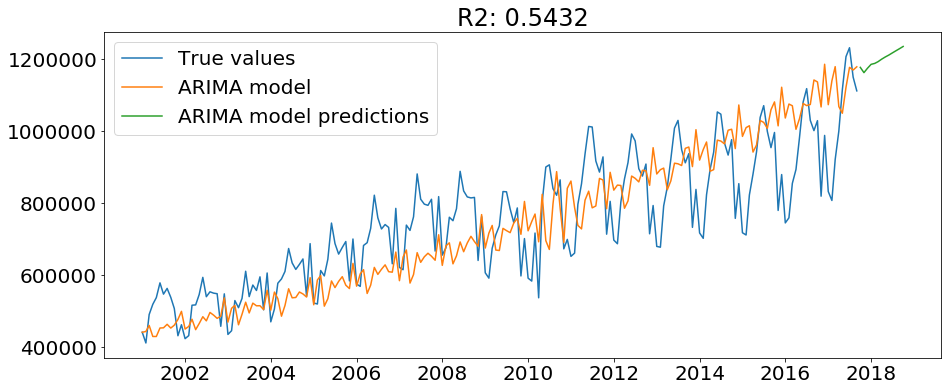

In [44]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(data['PASSENGERS'], label='True values')
plt.plot(predictions_ARIMA, label='ARIMA model')
plt.plot(ARIMA_forecasts, label='ARIMA model predictions')
plt.legend(fontsize=20, loc='upper left')
plt.title('R2: %.4f' % r2_score(data['PASSENGERS'], predictions_ARIMA));

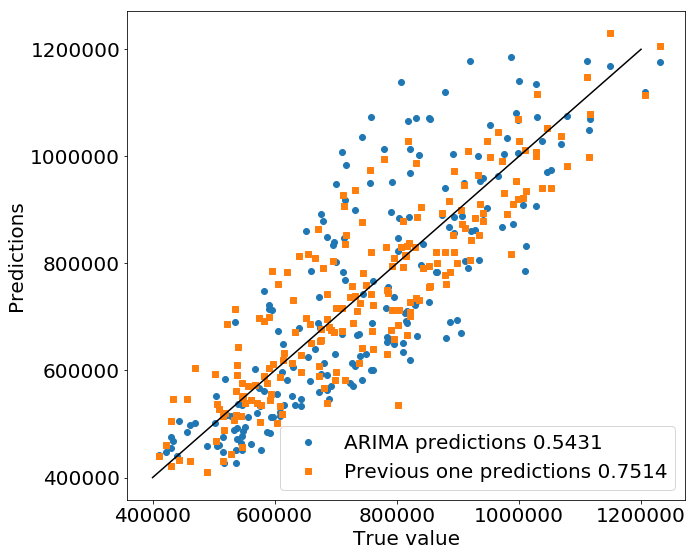

In [45]:
plt.figure(figsize=(10, 9))
plt.plot(data['PASSENGERS'], predictions_ARIMA, 'o', 
         label='ARIMA predictions ' + str(r2_score(data['PASSENGERS'], predictions_ARIMA))[:6])
plt.plot(data['PASSENGERS'], data['PASSENGERS'].shift(1), 's', 
         label='Previous one predictions ' + str(r2_score(data['PASSENGERS'].values[1:], 
                                                          data['PASSENGERS'].shift(1).values[1:]))[:6])
plt.plot([400000, 1200000], [400000, 1200000], 'k')
plt.xlabel('True value')
plt.ylabel('Predictions')
plt.legend();

## Usage of machine learning approaches

In many cases we can try our machine-learning models with carefully generated features

In [46]:
from sklearn.model_selection import TimeSeriesSplit

## Add features to the data

In [47]:
data.head()

,PASSENGERS
TIME,
2001-01-01,439753.0
2001-02-01,409945.0
2001-03-01,489109.0
2001-04-01,517510.0
2001-05-01,536096.0


In [48]:
# Additional useful features
data['YEAR_PASSENGERS'] = np.nan
data.loc[data.index[1:], 'YEAR_PASSENGERS'] = data['PASSENGERS'].rolling(window=12, min_periods=1).mean().values[:-1] 
data['MONTH'] = [x.month for x in data.index]
data['YEAR'] = [x.year for x in data.index]

In [49]:
months_data = pd.get_dummies(data['MONTH'])
months_data.columns = ['MONTH_' + str(int(x)) for x in months_data.columns]
months_data

,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12
TIME,,,,,,,,,,,,
2001-01-01,1,0,0,0,0,0,0,0,0,0,0,0
2001-02-01,0,1,0,0,0,0,0,0,0,0,0,0
2001-03-01,0,0,1,0,0,0,0,0,0,0,0,0
2001-04-01,0,0,0,1,0,0,0,0,0,0,0,0
2001-05-01,0,0,0,0,1,0,0,0,0,0,0,0
2001-06-01,0,0,0,0,0,1,0,0,0,0,0,0
2001-07-01,0,0,0,0,0,0,1,0,0,0,0,0
2001-08-01,0,0,0,0,0,0,0,1,0,0,0,0
2001-09-01,0,0,0,0,0,0,0,0,1,0,0,0


In [50]:
data = pd.concat((data, months_data), axis=1)

In [51]:
data

,PASSENGERS,YEAR_PASSENGERS,MONTH,YEAR,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12
TIME,,,,,,,,,,,,,,,,
2001-01-01,439753.0,NaN,1,2001,1,0,0,0,0,0,0,0,0,0,0,0
2001-02-01,409945.0,4.397530e+05,2,2001,0,1,0,0,0,0,0,0,0,0,0,0
2001-03-01,489109.0,4.248490e+05,3,2001,0,0,1,0,0,0,0,0,0,0,0,0
2001-04-01,517510.0,4.462690e+05,4,2001,0,0,0,1,0,0,0,0,0,0,0,0
2001-05-01,536096.0,4.640792e+05,5,2001,0,0,0,0,1,0,0,0,0,0,0,0
2001-06-01,577050.0,4.784826e+05,6,2001,0,0,0,0,0,1,0,0,0,0,0,0
2001-07-01,545747.0,4.949105e+05,7,2001,0,0,0,0,0,0,1,0,0,0,0,0
2001-08-01,561635.0,5.021729e+05,8,2001,0,0,0,0,0,0,0,1,0,0,0,0
2001-09-01,536832.0,5.096056e+05,9,2001,0,0,0,0,0,0,0,0,1,0,0,0


In [52]:
# Shift features
print(data['PASSENGERS'].head())
print(data['PASSENGERS'].shift(1).head())

TIME
2001-01-01    439753.0
2001-02-01    409945.0
2001-03-01    489109.0
2001-04-01    517510.0
2001-05-01    536096.0
Name: PASSENGERS, dtype: float64
TIME
2001-01-01         NaN
2001-02-01    439753.0
2001-03-01    409945.0
2001-04-01    489109.0
2001-05-01    517510.0
Name: PASSENGERS, dtype: float64


In [53]:
shifts_array = [1, 2, 3, 4, 12]
for shift in shifts_array:
  feature_name = 'N_SHIFT_' + str(shift)
  data[feature_name] = data['PASSENGERS'].shift(shift)

In [54]:
data.head()

,PASSENGERS,YEAR_PASSENGERS,MONTH,YEAR,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,...,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,N_SHIFT_1,N_SHIFT_2,N_SHIFT_3,N_SHIFT_4,N_SHIFT_12
TIME,,,,,,,,,,,,,,,,,,,,,
2001-01-01,439753.0,NaN,1,2001,1,0,0,0,0,0,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
2001-02-01,409945.0,439753.00,2,2001,0,1,0,0,0,0,...,0,0,0,0,0,439753.0,NaN,NaN,NaN,NaN
2001-03-01,489109.0,424849.00,3,2001,0,0,1,0,0,0,...,0,0,0,0,0,409945.0,439753.0,NaN,NaN,NaN
2001-04-01,517510.0,446269.00,4,2001,0,0,0,1,0,0,...,0,0,0,0,0,489109.0,409945.0,439753.0,NaN,NaN
2001-05-01,536096.0,464079.25,5,2001,0,0,0,0,1,0,...,0,0,0,0,0,517510.0,489109.0,409945.0,439753.0,NaN


In [55]:
filtered_data = data.dropna(axis=0)

In [56]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 189 entries, 2002-01-01 to 2017-09-01
Data columns (total 21 columns):
PASSENGERS         189 non-null float64
YEAR_PASSENGERS    189 non-null float64
MONTH              189 non-null int64
YEAR               189 non-null int64
MONTH_1            189 non-null uint8
MONTH_2            189 non-null uint8
MONTH_3            189 non-null uint8
MONTH_4            189 non-null uint8
MONTH_5            189 non-null uint8
MONTH_6            189 non-null uint8
MONTH_7            189 non-null uint8
MONTH_8            189 non-null uint8
MONTH_9            189 non-null uint8
MONTH_10           189 non-null uint8
MONTH_11           189 non-null uint8
MONTH_12           189 non-null uint8
N_SHIFT_1          189 non-null float64
N_SHIFT_2          189 non-null float64
N_SHIFT_3          189 non-null float64
N_SHIFT_4          189 non-null float64
N_SHIFT_12         189 non-null float64
dtypes: float64(7), int64(2), uint8(12)
memory usage: 17.0 KB


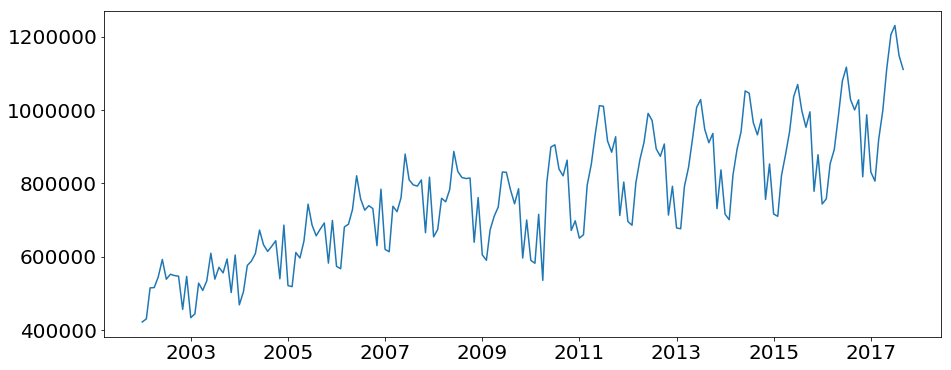

In [57]:
plt.plot(filtered_data.index, filtered_data['PASSENGERS']);

## Fit linear model to data and run cross validation

In [58]:
from sklearn.model_selection import TimeSeriesSplit

In [59]:
time_series_cross_validation = TimeSeriesSplit(n_splits=15)

In [60]:
inputs = filtered_data[['YEAR', 'YEAR_PASSENGERS', 
                        'N_SHIFT_1', 'N_SHIFT_2', 'N_SHIFT_3', 'N_SHIFT_4', 'N_SHIFT_12'] + 
                       list(months_data.columns)]
outputs = filtered_data['PASSENGERS']

In [61]:
for train_indexes, test_indexes in time_series_cross_validation.split(inputs):
  print(train_indexes, test_indexes)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] [24 25 26 27 28 29 30 31 32 33 34]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34] [35 36 37 38 39 40 41 42 43 44 45]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45] [46 47 48 49 50 51 52 53 54 55 56]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56] [57 58 59 60 61 62 63 64 65 66 67]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67] [68 69 70 71 72 73 74 75 76 77 78]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 

In [62]:
from sklearn.linear_model import LinearRegression

In [63]:
filtered_data['PASSENGERS_PREDICTIONS'] = np.nan
model = LinearRegression()
for training_indexes, test_indexes in time_series_cross_validation.split(inputs):
  training_inputs = inputs.iloc[training_indexes, :]
  training_outputs = outputs.iloc[training_indexes]
  
  test_inputs = inputs.iloc[test_indexes, :]
  test_outputs = outputs.iloc[test_indexes]
  
  model.fit(training_inputs, training_outputs)
  filtered_data.loc[filtered_data.index[test_indexes], 'PASSENGERS_PREDICTIONS'] = model.predict(test_inputs)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

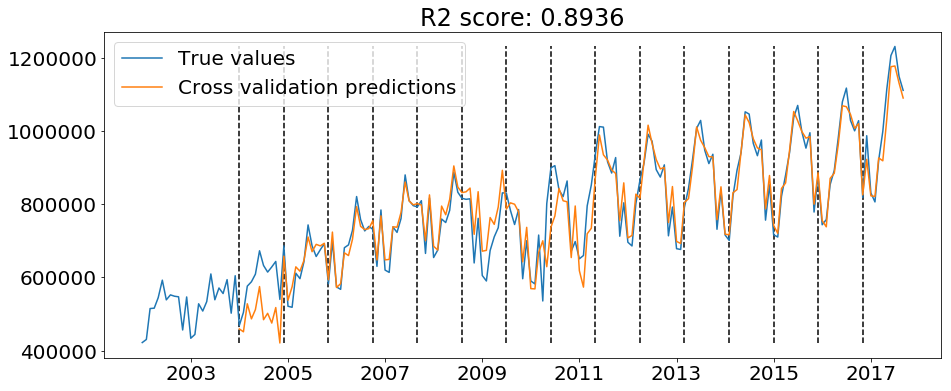

In [64]:
plt.plot(filtered_data.index, filtered_data['PASSENGERS'], label='True values');
plt.plot(filtered_data.index, filtered_data['PASSENGERS_PREDICTIONS'], 
         label='Cross validation predictions');
begin_indexes = [test_indexes[0] for train_indexes, test_indexes in time_series_cross_validation.split(inputs)]
plt.vlines(filtered_data.index[begin_indexes], 
           ymin=np.min(filtered_data['PASSENGERS']), 
           ymax=np.max(filtered_data['PASSENGERS']), linestyles='--')
plt.title('R2 score: ' + str(r2_score(filtered_data['PASSENGERS'].iloc[24:], 
                                      filtered_data['PASSENGERS_PREDICTIONS'].iloc[24:]))[:6])
plt.legend(loc='upper left');

## Examine features in linear model



In [65]:
import statsmodels.api as sm

In [66]:
inputs.loc[:, 'CONSTANT'] = 1

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [67]:
model = sm.OLS(outputs, inputs)

result = model.fit()

In [68]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             PASSENGERS   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     282.1
Date:                Wed, 20 Jun 2018   Prob (F-statistic):          1.95e-116
Time:                        10:35:50   Log-Likelihood:                -2220.6
No. Observations:                 189   AIC:                             4479.
Df Residuals:                     170   BIC:                             4541.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
YEAR             3042.8163   2322.976      1.310      0.192   -1542.777    7628.410
YEAR_PASSENGERS     0.3344      0.137      2.437      0.016       0.064       0.605
N_SHIFT_1           0.5246      0.072      7.295      0.000       0.383       0.667
N_SHIFT_2           0.1983      0.082      2.432      0.016       0.037       0.359
N_SHIFT_3           0.0335      0.081      0.415      0.678      -0.126       0.193
N_SHIFT_4          -0.3253      0.080     -4.069      0.000      -0.483      -0.167
N_SHIFT_12          0.1373      0.066      2.080      0.039       0.007       0.268
MONTH_1          -5.47e+05   3.56e+05     -1.535      0.127   -1.25e+06    1.57e+05
MONTH_2          -4.91e+05   3.57e+05     -1.377      0.170   -1.19e+06    2.13e+05
MONTH_3         -4.311e+05   3.56e+05     -1.211      0.228   -1.13e+06    2.72e+05
MONTH_4         -4.352e+05   3.55e+05     -1.224      0.222   -1.14e+06    2.66e+05
MONTH_5         -4.481e+05   3.55e+05     -1.262      0.209   -1.15e+06    2.53e+05
MONTH_6         -4.119e+05   3.55e+05     -1.162      0.247   -1.11e+06    2.88e+05
MONTH_7         -4.558e+05   3.54e+05     -1.287      0.200   -1.16e+06    2.43e+05
MONTH_8         -5.032e+05   3.54e+05     -1.420      0.157    -1.2e+06    1.96e+05
MONTH_9         -4.721e+05   3.54e+05     -1.332      0.184   -1.17e+06    2.27e+05
MONTH_10        -4.048e+05   3.54e+05     -1.143      0.255    -1.1e+06    2.94e+05
MONTH_11        -5.642e+05   3.54e+05     -1.593      0.113   -1.26e+06    1.35e+05
MONTH_12        -4.017e+05   3.54e+05     -1.133      0.259    -1.1e+06    2.98e+05
CONSTANT        -5.566e+06   4.26e+06     -1.307      0.193    -1.4e+07    2.84e+06
==============================================================================
Omnibus:                       67.457   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              666.051
Skew:                          -1.002   Prob(JB):                    2.34e-145
Kurtosis:                      11.976   Cond. No.                     1.53e+22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.81e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [69]:
filtered_data['PASSENGERS_PREDICTIONS_TRAINING'] = result.predict(inputs)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


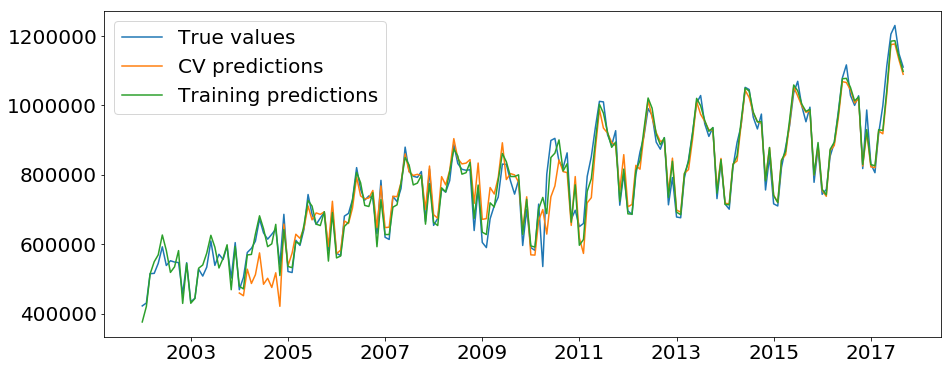

In [70]:
plt.plot(filtered_data.index, filtered_data['PASSENGERS'], label='True values');
plt.plot(filtered_data.index, filtered_data['PASSENGERS_PREDICTIONS'], 
         label='CV predictions');
plt.plot(filtered_data.index, filtered_data['PASSENGERS_PREDICTIONS_TRAINING'], 
         label='Training predictions');
plt.legend(loc='upper left');

## Get predictions for new points using the given linear regression model

In [71]:
prediction_length = 12
new_data = pd.DataFrame(np.nan * np.zeros((prediction_length, len(filtered_data.columns))), 
                        columns=filtered_data.columns)

In [72]:
new_data.head()

,PASSENGERS,YEAR_PASSENGERS,MONTH,YEAR,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,...,MONTH_10,MONTH_11,MONTH_12,N_SHIFT_1,N_SHIFT_2,N_SHIFT_3,N_SHIFT_4,N_SHIFT_12,PASSENGERS_PREDICTIONS,PASSENGERS_PREDICTIONS_TRAINING
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
from dateutil.relativedelta import relativedelta

In [74]:
new_data.index = [filtered_data.index[-1] + relativedelta(months=x) for x in range(1, prediction_length + 1)]

In [75]:
new_data.head()

,PASSENGERS,YEAR_PASSENGERS,MONTH,YEAR,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,...,MONTH_10,MONTH_11,MONTH_12,N_SHIFT_1,N_SHIFT_2,N_SHIFT_3,N_SHIFT_4,N_SHIFT_12,PASSENGERS_PREDICTIONS,PASSENGERS_PREDICTIONS_TRAINING
2017-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
augmented_data = pd.concat((filtered_data, new_data), axis=0)

In [77]:
augmented_data.tail(15)

,PASSENGERS,YEAR_PASSENGERS,MONTH,YEAR,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,...,MONTH_10,MONTH_11,MONTH_12,N_SHIFT_1,N_SHIFT_2,N_SHIFT_3,N_SHIFT_4,N_SHIFT_12,PASSENGERS_PREDICTIONS,PASSENGERS_PREDICTIONS_TRAINING
2017-07-01,1230783.0,9.879517e+05,7.0,2017.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1206039.0,1114166.0,998868.0,919996.0,1117071.0,1.177474e+06,1.186913e+06
2017-08-01,1149035.0,9.974277e+05,8.0,2017.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1230783.0,1206039.0,1114166.0,998868.0,1028804.0,1.131005e+06,1.140041e+06
2017-09-01,1110824.0,1.007447e+06,9.0,2017.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1149035.0,1230783.0,1206039.0,1114166.0,1000315.0,1.089965e+06,1.098115e+06
2017-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
def generate_features(data, shifts_array=[1, 2, 3, 4, 12]):
  # Additional useful features
  data['YEAR_PASSENGERS'] = np.nan
  data.loc[data.index[1:], 'YEAR_PASSENGERS'] = data['PASSENGERS'].rolling(window=12, min_periods=1).mean().values[:-1] 
  data['MONTH'] = [x.month for x in data.index]
  data['YEAR'] = [x.year for x in data.index]
  
  months_data = pd.get_dummies(data['MONTH'])
  months_data.columns = ['MONTH_' + str(int(x)) for x in months_data.columns]
  for column_name in months_data.columns:
    data[column_name] = months_data[column_name]
  
  shifts_array = [1, 2, 3, 4, 12]
  for shift in shifts_array:
    feature_name = 'N_SHIFT_' + str(shift)
    data[feature_name] = data['PASSENGERS'].shift(shift)
                                                  
  return data

In [79]:
augmented_data = generate_features(augmented_data)

In [80]:
augmented_data.tail(15)

,PASSENGERS,YEAR_PASSENGERS,MONTH,YEAR,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,...,MONTH_10,MONTH_11,MONTH_12,N_SHIFT_1,N_SHIFT_2,N_SHIFT_3,N_SHIFT_4,N_SHIFT_12,PASSENGERS_PREDICTIONS,PASSENGERS_PREDICTIONS_TRAINING
2017-07-01,1230783.0,9.879517e+05,7,2017,0,0,0,0,0,0,...,0,0,0,1206039.0,1114166.0,998868.0,919996.0,1117071.0,1.177474e+06,1.186913e+06
2017-08-01,1149035.0,9.974277e+05,8,2017,0,0,0,0,0,0,...,0,0,0,1230783.0,1206039.0,1114166.0,998868.0,1028804.0,1.131005e+06,1.140041e+06
2017-09-01,1110824.0,1.007447e+06,9,2017,0,0,0,0,0,0,...,0,0,0,1149035.0,1230783.0,1206039.0,1114166.0,1000315.0,1.089965e+06,1.098115e+06
2017-10-01,NaN,1.016656e+06,10,2017,0,0,0,0,0,0,...,1,0,0,1110824.0,1149035.0,1230783.0,1206039.0,1028065.0,NaN,NaN
2017-11-01,NaN,1.015619e+06,11,2017,0,0,0,0,0,0,...,0,1,0,NaN,1110824.0,1149035.0,1230783.0,818043.0,NaN,NaN
2017-12-01,NaN,1.035376e+06,12,2017,0,0,0,0,0,0,...,0,0,1,NaN,NaN,1110824.0,1149035.0,986981.0,NaN,NaN
2018-01-01,NaN,1.040754e+06,1,2018,1,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,1110824.0,830946.0,NaN,NaN
2018-02-01,NaN,1.066980e+06,2,2018,0,1,0,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,806126.0,NaN,NaN
2018-03-01,NaN,1.104244e+06,3,2018,0,0,1,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,919996.0,NaN,NaN
2018-04-01,NaN,1.134952e+06,4,2018,0,0,0,1,0,0,...,0,0,0,NaN,NaN,NaN,NaN,998868.0,NaN,NaN


In [81]:
input_variables = (['YEAR', 'YEAR_PASSENGERS', 'N_SHIFT_1', 'N_SHIFT_2', 'N_SHIFT_3', 'N_SHIFT_4', 'N_SHIFT_12'] + 
                   list(months_data.columns))
inputs = filtered_data[input_variables]
outputs = filtered_data['PASSENGERS']

In [82]:
model = sm.OLS(outputs, inputs)

result_model = model.fit()

In [83]:
augmented_data['PASSENGERS_PREDICTIONS_TRAINING'] = result_model.predict(augmented_data[input_variables])

In [84]:
def fill_prediction(data, input_variables, output_variable, output_target_variable, model, start_index=None):
  data = pd.DataFrame.copy(data)
  if start_index is None:
    start_index = np.min(np.where(np.isnan(data[output_variable]))[0])
  
  # the fill algorithm isn't optimal, it is just to demonstrate how to get the predictions in this case.
  for index in np.arange(start_index, data.shape[0]):
    data = generate_features(data)
    data[output_target_variable] = model.predict(data[input_variables])
    nan_indexes = np.where(np.isnan(data[output_variable]))[0]
    data.loc[data.index[nan_indexes], output_variable] = data.loc[data.index[nan_indexes], output_target_variable]
  return data[output_target_variable]  

In [85]:
augmented_data['PASSENGERS_PREDICTIONS_TRAINING'] = fill_prediction(augmented_data, input_variables, 
                                                                    'PASSENGERS', 'PASSENGERS_PREDICTIONS_TRAINING', 
                                                                    result_model)

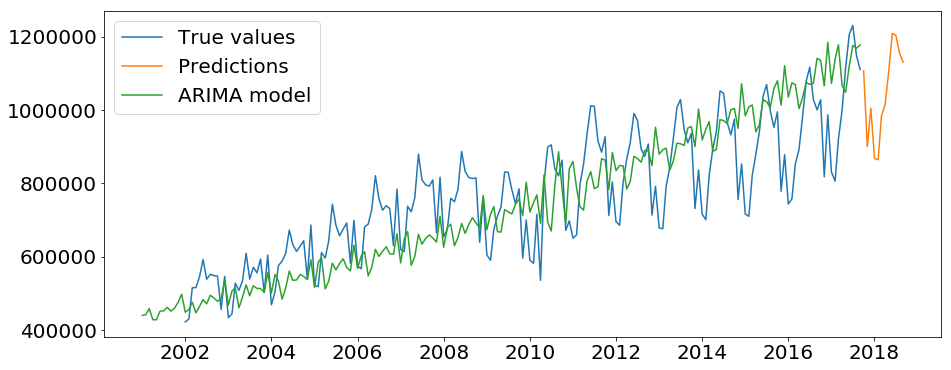

In [86]:
plt.plot(augmented_data.index, augmented_data['PASSENGERS'], label='True values');
plt.plot(augmented_data.index[-prediction_length:], 
         augmented_data['PASSENGERS_PREDICTIONS_TRAINING'].values[-prediction_length:], 
         label='Predictions');
plt.plot(predictions_ARIMA.index, predictions_ARIMA.values, label='ARIMA model')
plt.legend(loc='upper left');